In [60]:
def make_initial_data(get_target_function):
    torch.manual_seed(42)
    
    x = torch.linspace(-5, 5, 10000)
    y = get_target_function(x) + torch.normal(0, 1, size=x.size())
    return x, y

def make_test_data(get_target_function):
    torch.manual_seed(66)
    x_test = torch.linspace(-5, 5, 10000)
    y_test = get_target_function(x_test) + torch.normal(0, 1, size=x_test.size())
    y_perfect = get_target_function(x_test)
    
    x_test = torch.unsqueeze(x_test, dim=1)
    y_test = torch.unsqueeze(y_test, dim=1)
    y_perfect = torch.unsqueeze(y_perfect, dim=1)
    return x_test, y_test, y_perfect

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np
from torchbnn.utils import freeze, unfreeze

def bnn_model(mu=0, sigma=0.1, dropout_prob=0, width=100, depth=2):
    layers = [bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=1, out_features=width),
              nn.Tanh(),
              nn.Dropout(p=dropout_prob)]
    for i in range(depth - 1):
        layers += [bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=width, out_features=width),
                   nn.Tanh(), nn.Dropout(p=dropout_prob),]
    layers += [bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=width, out_features=1)]
    model_nn = nn.Sequential(*layers)
    return model_nn

def train_bnn_model(model_nn, x, y, kl_weight=0.01, learning_rate=0.01, epochs=4000):
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    # kl weight started as 0.01
    kl_weight = kl_weight
    optimizer_nn = optim.Adam(model_nn.parameters(), lr=learning_rate)
    for step in range(epochs):
        pre = model_nn(torch.unsqueeze(x, dim=1))
        mse = mse_loss(pre, torch.unsqueeze(y, dim=1))
        kl = kl_loss(model_nn)
        cost = mse + kl_weight*kl
        optimizer_nn.zero_grad()
        cost.backward()
        optimizer_nn.step()
        if step%500 == 0:
            print(step, "/", epochs)

def get_dist(model, x_test, samples=10000):
    freeze(model)
    models_result = np.array([model(x_test).data.numpy() for k in range(samples)])
    models_result = models_result[:,:,0]    
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])
    return mean_values, std_values

In [62]:


mu=0
sigma=0.1
dropout_prob=0
width=100
depth=2
epochs=500
samples=100

def get_target_function(x):
        # True function is x * sin(x + 5)
        return x*torch.sin(x+5)
x, y = make_initial_data(get_target_function)
x_test, y_test, y_perfect = make_test_data(get_target_function)

model = bnn_model(mu=mu, sigma=sigma, dropout_prob=dropout_prob, width=width, depth=depth)
train_bnn_model(model, x, y, epochs=epochs)
mean_values, std_values = get_dist(model, x_test, samples=samples)

0 / 500


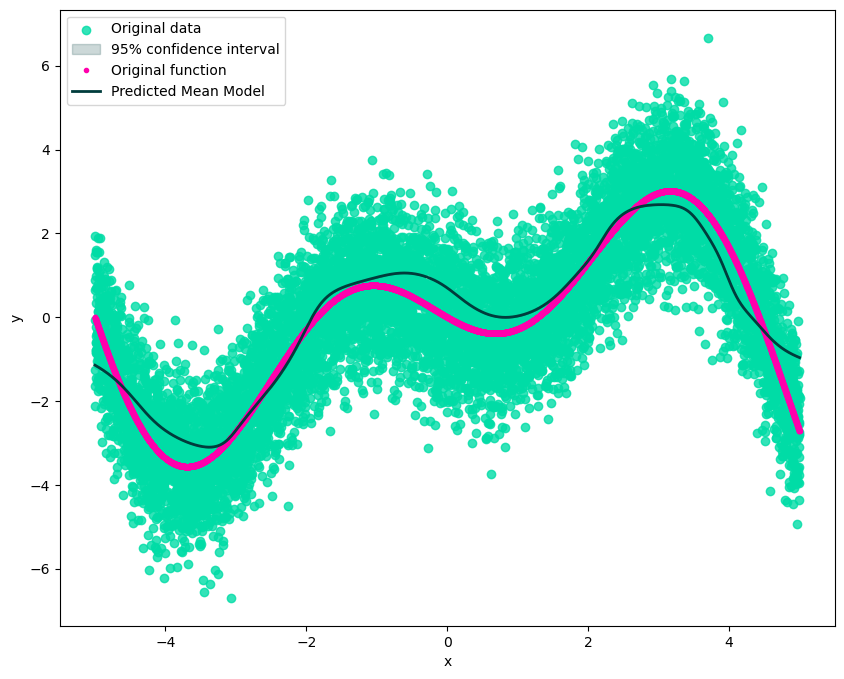

In [63]:
import matplotlib.pyplot as plt
def plot_model(x, y, x_test, y_perfect, mean_values, std_values, title=None, filename=None, reverse_plot=False):
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, alpha=0.8, label="Original data", color="#00dca6ff")
    plt.fill_between(x_test.data.numpy().T[0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='#003c3cff',
                     label='95% confidence interval')
    if reverse_plot == False:
        plt.plot(x_test.data.numpy(),y_perfect.data.numpy(),'.',color="#FF00ACFF", lw=2,label='Original function')
        plt.plot(x_test.data.numpy(),mean_values,color='#003c3cff',lw=2,label='Predicted Mean Model')
    else:
        plt.plot(x_test.data.numpy(),mean_values,color='#003c3cff',lw=2,label='Predicted Mean Model')
        plt.plot(x_test.data.numpy(),y_perfect.data.numpy(),'.',color="#FF00ACFF", lw=2,label='Original function')
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

plot_model(x, y, x_test, y_perfect, mean_values, std_values)